In [1]:
!nvidia-smi

Wed Jul  8 08:55:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:04:00.0 Off |                  N/A |
| 23%   28C    P8    16W / 250W |   3630MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 23%   28C    P8    16W / 250W |    753MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
import os

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

import time

import torchvision
from torchvision import transforms as T

import tqdm

import warnings
warnings.filterwarnings('ignore')
torch.cuda.is_available()

True

In [3]:
path_data = '/home/user/michigan/data/AGM01/'
device = 'cuda'

In [4]:
root_dir = "/home/user/michigan/data/AGM01"
csv_file = "/home/user/michigan/data/AGM/AGM_Metadata.csv"
meta_data = pd.read_csv(csv_file)

In [5]:
meta_data.pop("Group_Index")
meta_data.drop_duplicates()

,Metadata_Image_Metadata_Compound,Metadata_Image_Metadata_Concentration,Metadata_PlateID,Metadata_WellID,COND
0,DMSO,0.000,Week1_22123,B02,NC
4,cytochalasin B,30.000,Week1_22123,B03,NaN
8,cytochalasin B,10.000,Week1_22123,B04,NaN
12,cytochalasin B,3.000,Week1_22123,B05,NaN
16,cytochalasin B,1.000,Week1_22123,B06,NaN
...,...,...,...,...,...
3580,PD-150606,0.500,Week9_39301,G07,NaN
3584,PD-150606,0.150,Week9_39301,G08,NaN
3588,PD-150606,0.050,Week9_39301,G09,NaN
3592,PD-150606,0.015,Week9_39301,G10,NaN


In [6]:
# week_id = "Single_Week1_22123"
# image_path = os.path.join(root_dir, week_id)
# image_files = np.array([x.path for x in os.scandir(image_path) if x.name.endswith(".tif")])

In [7]:
week_list=["Week1_22123"]
Week1_df = pd.read_csv(root_dir+"/features/"+week_list[0]+"_Joined.csv")

## Define Dataloader

In [8]:
class AGMDS(D.Dataset): ##Transformed
    def __init__(self, df, week, transform=None, channels=[0,1,2]):
        self.week = week
        self.df = df
        self.root_path = "/home/user/michigan/data/AGM01/"
        self.channels = channels
        self.img_dir = self.root_path+self.week
        self.len = df.shape[0]
        self.transform = transform
        
    @staticmethod
    def _load_img_as_tensor(self, file_name):
        with Image.open(file_name) as img:
            img = img.resize((112,112),resample=Image.NEAREST)
            pixels = np.asarray(img)
            pixels = pixels.astype('float32')
            # Scale them to 0~1
            maxmum = pixels.max()
            pixels = pixels / maxmum
            return T.ToTensor()(pixels)

        
    def _get_img_path(self, index, channel):
        well, field, cell_idx = self.df.iloc[index]["Metadata_WellID_Nuclei"], self.df.iloc[index]["Metadata_FieldID_Nuclei"], self.df.iloc[index]["ObjectNumber_Nuclei"]
        return "/home/user/michigan/data/AGM01/Single_%s/%s_%s_%s_%s.tif" % (self.week, well, field, ("Ch" + str(channel)), cell_idx)
    
    def __getitem__(self, index):
        paths = [self._get_img_path(index, ch) for ch in self.channels]
        img = torch.cat([self._load_img_as_tensor(self, img_path) for img_path in paths])
        if self.transform is not None:
            img = self.transform(img)
        
        return img, self.df.iloc[index]["Metadata_WellID_Nuclei"] 

    def __len__(self):
        return self.len

In [9]:
transform = T.Compose(
    [
        T.ToPILImage(),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.RandomApply([T.RandomRotation(90)]),
        T.ToTensor()
    ])
AGMData = AGMDS(df = Week1_df, week = week_list[0], transform = transform)


In [10]:
images, well = iter(D.DataLoader(AGMDS(df = Week1_df, week = week_list[0], transform = transform), batch_size=16, shuffle=False)).next()
o_images, _ = iter(D.DataLoader(AGMDS(df= Week1_df, week = week_list[0]), batch_size=16, shuffle=False)).next()



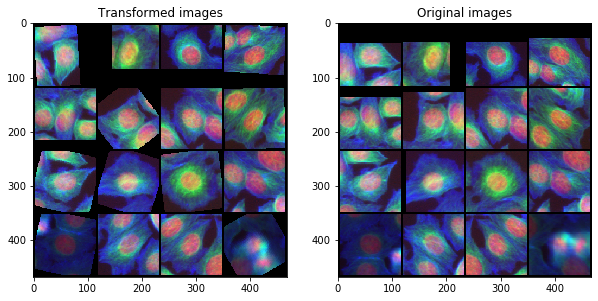

In [11]:
def show_image(img):
#     img = to_img(img)
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
plt.figure(figsize=(10, 10))
ax = plt.subplot(1,2,1)
ax.set_title('Transformed images')
show_image(torchvision.utils.make_grid(images,4, 4))
ax = plt.subplot(1,2,2)
ax.set_title('Original images')
show_image(torchvision.utils.make_grid(o_images,4, 4))

## Define model structure

In [12]:
latent_dims = 64
capacity = 64
variational_beta = 1

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 56 x 56
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: 2c x 28 x 28
        self.conv3 = nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=4, stride=2, padding=1) # out: 4c x 14 x 14
        
        self.fc_mu = nn.Linear(in_features=c*4*14*14, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*4*14*14, out_features=latent_dims)
            
    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = F.sigmoid(self.conv2(x))
        x = F.sigmoid(self.conv3(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*4*14*14)
        self.conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*4, 14, 14) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.sigmoid(self.conv3(x))
        x = F.sigmoid(self.conv2(x))
        x = F.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 112*112), x.view(-1, 112*112), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    


In [14]:
# device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder().to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 11001603


## Training

In [15]:
batch_size = 64
learning_rate = 1e-3

loader = D.DataLoader(AGMData, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)


In [23]:
for i in os.listdir():
    if i == "model%s_%s.pt" % (latent_dims, capacity):
        vae.load_state_dict(torch.load(i))
    if i == "opt%s_%s.pt" % (latent_dims, capacity):
        optimizer.load_state_dict(torch.load(i))
#         for state in optimizer.state.values():
#             for k, v in state.items():
#                 if torch.is_tensor(v):
#                     state[k] = v.cuda()

In [16]:
# vae = nn.DataParallel(vae)#, device_ids=[0,1,2])
vae = vae.cuda()#to(device)

In [ ]:
train_loss = []
num_epochs = 50
print('Training ...')
tlen = len(loader)
batch_idx = 0
try:
    for epoch in range(num_epochs):
        
        for j, (image_batch, label) in enumerate(loader): # image_batch is a batch (16) of 3 channels images tensor; 
            image_batch = image_batch.to(device)
            #vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)         
            # reconstruction error
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
#             if j ==6:
#                 break
            train_loss.append(loss.item())
            if j % 100 == 0:
                result = "[%d/%d][%d/%d]\tLoss:%f\tlatent_dims:%d\t%s\n" % (epoch, num_epochs, j, len(loader),
                                                   np.cumsum(train_loss)[len(train_loss)-1]/len(train_loss), latent_dims, time.ctime())
                print(result)
                f=open("./train_log/vae_AGM_train%s_%s.log" % (latent_dims,capacity) , "a")
                f.write(result)
                f.close
        torch.save(vae.state_dict(), "vae3l_%s_%s.pt" % (latent_dims,capacity))
        torch.save(optimizer.state_dict(), "opt-vae3l_%s_%s.pt" % (latent_dims,capacity))
except KeyboardInterrupt:
    print("Interrupting... Saving model...")
    torch.save(vae.state_dict(), "vae3l_%s_%s.pt" % (latent_dims,capacity))
    torch.save(optimizer.state_dict(), "opt-vae3l_%s_%s.pt" % (latent_dims,capacity))


Training ...
[0/50][0/422]	Loss:1405670.000000	latent_dims:64	Wed Jul  8 09:08:06 2020

[0/50][100/422]	Loss:1418132.835396	latent_dims:64	Wed Jul  8 09:19:58 2020

[0/50][200/422]	Loss:1410599.488184	latent_dims:64	Wed Jul  8 09:31:47 2020

[0/50][300/422]	Loss:1405836.173588	latent_dims:64	Wed Jul  8 09:43:46 2020

[0/50][400/422]	Loss:1403097.163342	latent_dims:64	Wed Jul  8 09:55:11 2020

[1/50][0/422]	Loss:1401392.935284	latent_dims:64	Wed Jul  8 09:57:44 2020

[1/50][100/422]	Loss:1400601.495937	latent_dims:64	Wed Jul  8 10:09:00 2020

[1/50][200/422]	Loss:1399741.146469	latent_dims:64	Wed Jul  8 10:20:39 2020

[1/50][300/422]	Loss:1399060.258126	latent_dims:64	Wed Jul  8 10:32:13 2020

[1/50][400/422]	Loss:1398615.844471	latent_dims:64	Wed Jul  8 10:44:52 2020

[2/50][0/422]	Loss:1397994.735799	latent_dims:64	Wed Jul  8 10:47:25 2020

[2/50][100/422]	Loss:1397770.239947	latent_dims:64	Wed Jul  8 10:58:59 2020

[2/50][200/422]	Loss:1397439.029665	latent_dims:64	Wed Jul  8 11:10:4

## Reconstruct images

In [26]:
images, well = iter(original_loader).next()
original_loader = D.DataLoader(AGMDS(df= Week1_df, week = week_list[0]), batch_size=64, shuffle=False)

Original images


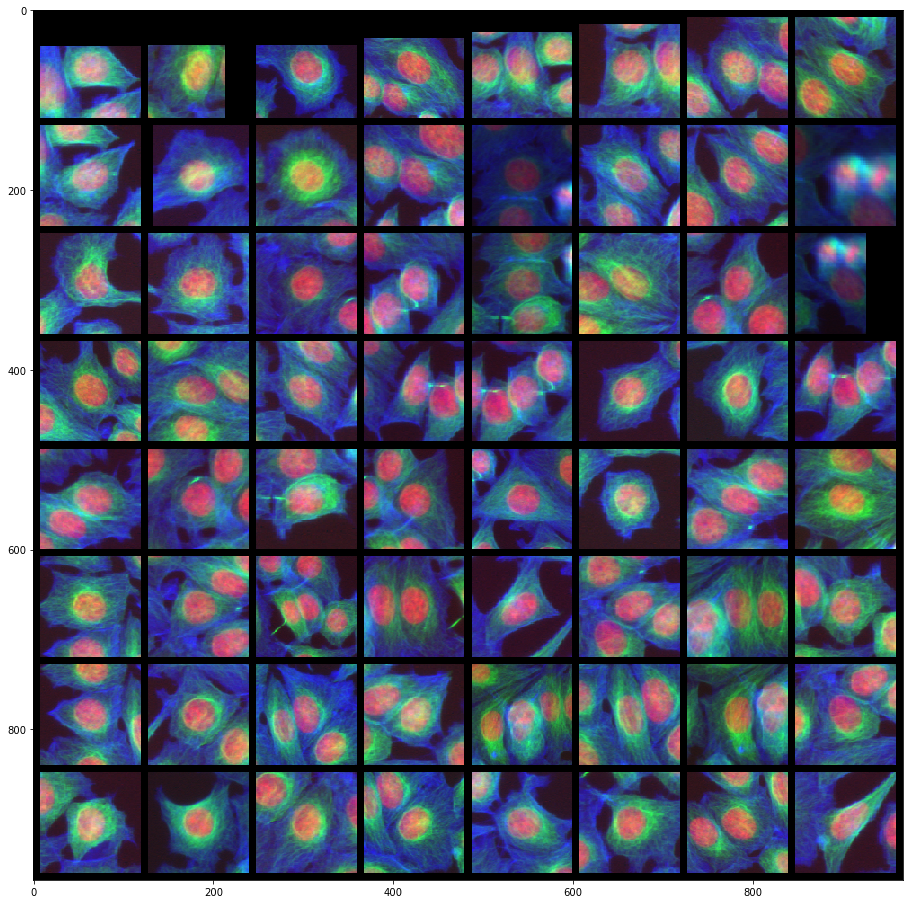

In [31]:
print('Original images')
plt.figure(figsize=(16, 16))
show_image(torchvision.utils.make_grid(images,8,8))
plt.show()

VAE reconstruction:


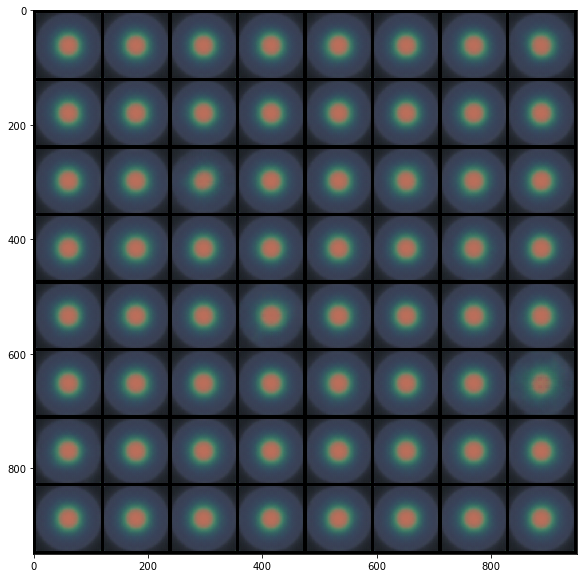

In [28]:
print('VAE reconstruction:')
with torch.no_grad():
    plt.figure(figsize=(10, 10))
    images = images.to(device)
    recon_images, _, _ = vae(images)
    recon_images = recon_images.cpu()
#     recon_images = to_img(recon_images)
    np_imagegrid = torchvision.utils.make_grid(recon_images, 8, 6).numpy()
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()